In [1]:
!wget people.csail.mit.edu/celiu/CVPR2010/FMD/FMD.zip
!unzip "/content/FMD.zip"

--2023-03-18 18:51:13--  http://people.csail.mit.edu/celiu/CVPR2010/FMD/FMD.zip
Resolving people.csail.mit.edu (people.csail.mit.edu)... 128.30.2.133
Connecting to people.csail.mit.edu (people.csail.mit.edu)|128.30.2.133|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58627619 (56M) [application/zip]
Saving to: ‘FMD.zip’

FMD.zip             100%[===================>]  55.91M  12.3MB/s    in 5.2s    

2023-03-18 18:51:19 (10.8 MB/s) - ‘FMD.zip’ saved [58627619/58627619]

Archive:  /content/FMD.zip
   creating: mask/
   creating: mask/fabric/
  inflating: mask/fabric/fabric_moderate_001_new.jpg  
  inflating: mask/fabric/fabric_moderate_002_new.jpg  
  inflating: mask/fabric/fabric_moderate_003_new.jpg  
  inflating: mask/fabric/fabric_moderate_004_new.jpg  
  inflating: mask/fabric/fabric_moderate_005_new.jpg  
  inflating: mask/fabric/fabric_moderate_006_new.jpg  
  inflating: mask/fabric/fabric_moderate_007_new.jpg  
  inflating: mask/fabric/fabric_moderate_0

In [2]:
import random
import matplotlib.pyplot as plt
import os
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import imgaug.augmenters as iaa
from sklearn import preprocessing

# ***Fetch dataset***

In [3]:
def fetch(dir):
    data_dir = dir

    categories = os.listdir(data_dir)

    images = []
    labels = []

    for category in categories:
        path = os.path.join(data_dir, category)
        for img in os.listdir(path):
            if img.endswith('.jpg'):
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                images.append(img_array)
                labels.append(category)
    return categories, images, labels

In [4]:
data_dir = "/content/image"

categories, images, labels = fetch(data_dir)

# ***Visualize dataset***

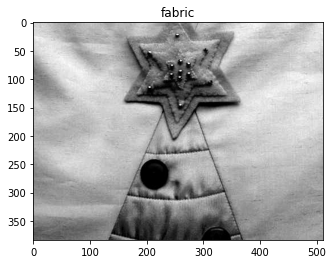

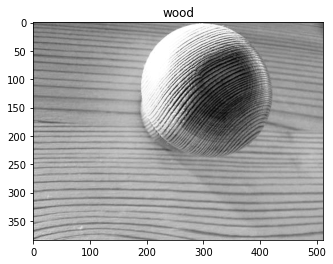

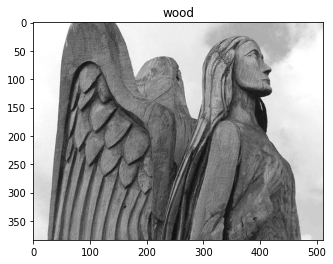

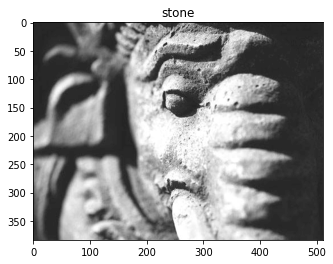

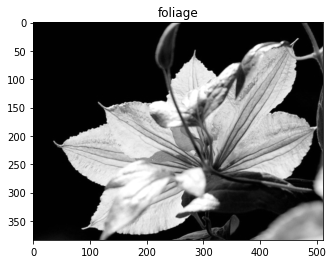

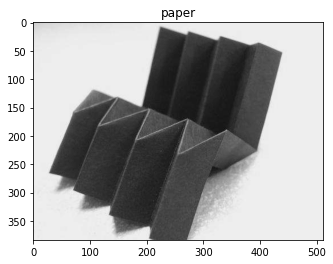

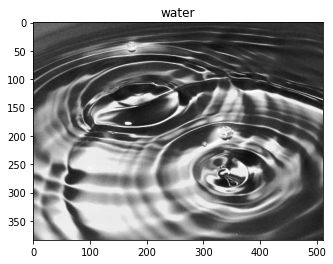

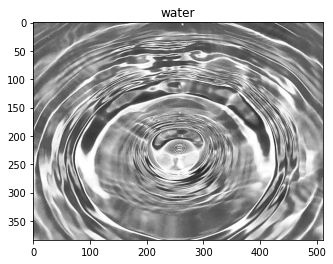

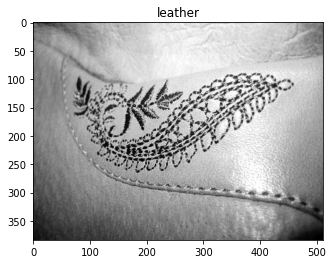

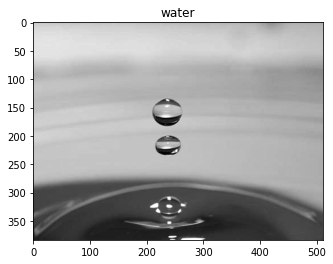

In [5]:
indices = []
for i in range(0,10):
    index = random.randint(0, len(images))
    indices.append(index)

for i in indices:
    plt.title(labels[i])
    plt.imshow(images[i], cmap='gray')
    plt.show()

# ***Data augmentation***

In [6]:
augmentation = iaa.Sequential([
    # Flip
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),

])

In [7]:
augmented_images = np.array(augmentation(images=images))

images = np.concatenate((images, augmented_images), axis=0)
labels.extend(labels)
print(len(augmented_images))

1000


# ***Visualize augmented dataset***

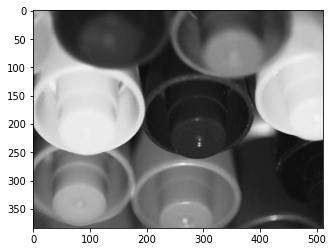

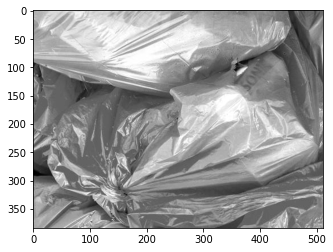

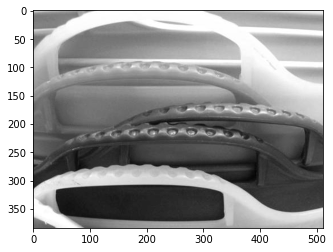

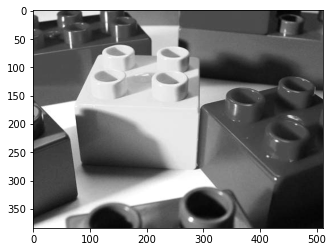

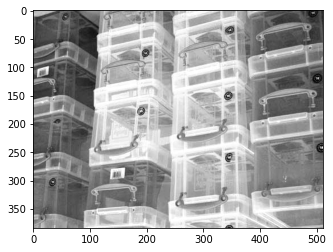

In [8]:
for img in augmented_images[:5]:
    plt.imshow(img, cmap='gray')
    plt.show() 

# ***Discover new dataset shape***

In [9]:
images = np.array(images)
print("images shape:", images.shape)
print(len(labels))

images shape: (2000, 384, 512)
2000


# ***Encode labels from text to integers***

In [10]:
images = np.array(images)
labels = np.array(labels)
label_encoder = preprocessing.LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

In [11]:
print(np.unique(labels))
print(np.unique(encoded_labels))

['fabric' 'foliage' 'glass' 'leather' 'metal' 'paper' 'plastic' 'stone'
 'water' 'wood']
[0 1 2 3 4 5 6 7 8 9]


# ***Split dataset to train and test***

In [12]:

def train_test_split(images, encoded_labels, test_size=0.3, random_state=None):
    if random_state:
        random.seed(random_state)
    
    indices = list(range(len(images)))
    random.shuffle(indices)
    
    split_index = int(len(indices) * (1 - test_size))
    
    train_indices = indices[:split_index]
    test_indices = indices[split_index:]
    
    x_train = images[train_indices]
    x_test = images[test_indices]
    y_train = encoded_labels[train_indices]
    y_test = encoded_labels[test_indices]
    
    return x_train, x_test, y_train, y_test


In [13]:
x_train, x_test, y_train, y_test = train_test_split(images, encoded_labels, test_size=0.3, random_state=42)

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (1400, 384, 512)
y_train shape: (1400,)
x_test shape: (600, 384, 512)
y_test shape: (600,)


# ***GLCM Features Extraction***

In [14]:
def generate_glcm(images, distances, angles):
    glcm_features = []
    for img in images:
        # convert image to PIL Image object if it's not already
        if not isinstance(img, Image.Image):
            img = Image.fromarray(img)

        # check image dimensions
        width, height = img.size
        if width == 0 or height == 0:
            continue

        # compute the gray-level co-occurrence matrix
        glcm = np.zeros((256, 256, len(distances), len(angles)))
        for y in range(height):
            for x in range(width):
                for d, distance in enumerate(distances):
                    for a, angle in enumerate(angles):
                        x_offset = int(distance * np.cos(angle))
                        y_offset = int(distance * np.sin(angle))
                        x2 = x + x_offset
                        y2 = y + y_offset
                        if x2 < 0 or x2 >= width or y2 < 0 or y2 >= height:
                            continue
                        i = img.getpixel((x, y))
                        j = img.getpixel((x2, y2))
                        glcm[i, j, d, a] += 1
        # compute texture features from the GLCM
        contrast = 0
        dissimilarity = 0
        homogeneity = 0
        energy = 0
        correlation = 0
        for d, distance in enumerate(distances):
            for a, angle in enumerate(angles):
                glcm_d_a = glcm[:, :, d, a]
                px = np.sum(glcm_d_a)
                py = np.sum(glcm_d_a.T)
                mu_x = np.sum(np.arange(256) * np.sum(glcm_d_a, axis=1))
                mu_y = np.sum(np.arange(256) * np.sum(glcm_d_a, axis=0))
                sigma_x = np.sqrt(np.sum(np.square(np.arange(256) - mu_x) * np.sum(glcm_d_a, axis=1)))
                sigma_y = np.sqrt(np.sum(np.square(np.arange(256) - mu_y) * np.sum(glcm_d_a, axis=0)))
                p_xy = glcm_d_a / (px * py + 1e-6)

                contrast += np.sum(np.square(np.arange(256)[:, np.newaxis] - np.arange(256)[np.newaxis, :]) * p_xy)
                dissimilarity += np.sum(np.abs(np.arange(256)[:, np.newaxis] - np.arange(256)[np.newaxis, :]) * p_xy)
                homogeneity += np.sum(p_xy / (1 + np.square(np.arange(256)[:, np.newaxis] - np.arange(256)[np.newaxis, :])))
                energy += np.sum(np.square(p_xy))
                correlation += np.sum((np.arange(256)[:, np.newaxis] - mu_x) * (np.arange(256)[np.newaxis, :] - mu_y) * p_xy / (sigma_x * sigma_y + 1e-6))

        # concatenate the features into a single array
        features = np.array([contrast, dissimilarity, homogeneity, energy, correlation]).flatten()
        glcm_features.append(features)
    return glcm_features

In [15]:
# define the distance and angle offsets
distances = [1]
angles = [0]
glcm_train = generate_glcm(x_train,distances,angles)
glcm_train = np.array(glcm_train)
print("glcm_train shape:", glcm_train.shape)

glcm_train shape: (1400, 5)


In [16]:
glcm_test = generate_glcm(x_test,distances,angles)
glcm_test = np.array(glcm_test)
print("glcm_test shape:", glcm_test.shape)

glcm_test shape: (600, 5)


# ***KNN Classifier***

In [17]:
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

In [18]:
def predict_knn(X_train, y_train, X_test, k=1):
    """
    Predict labels for test data using KNN algorithm
    
    Arguments:
    X_train -- training features
    y_train -- training labels
    X_test -- test features
    k -- number of nearest neighbors to consider (default: 1)
    
    Returns:
    y_pred -- predicted labels for test data
    """
    y_pred = []
    
    for test_sample in X_test:
        distances = []
        for i, train_sample in enumerate(X_train):
            dist = euclidean_distance(test_sample, train_sample)
            distances.append((dist, y_train[i]))
        distances = sorted(distances)[:k]
        k_nearest_labels = [label for (_, label) in distances]
        y_pred.append(max(set(k_nearest_labels), key=k_nearest_labels.count))
    
    return np.array(y_pred)

In [19]:
# Predict labels for testing set
y_pred = predict_knn(glcm_train, y_train, glcm_test,k=1)

In [20]:
# Calculate accuracy of model
def accuracy(y_true, y_pred):
    correct = np.sum(y_true == y_pred)
    return correct / len(y_true)


In [21]:
accuracy_score = accuracy(y_test, y_pred)
print(f"Accuracy when using Extract Features: {accuracy_score*100}%")

Accuracy when using Extract Features: 71.0%
